# Problem 1 - G dwarf problem

The G dwarf problem, first pointed out by van den Bergh (1962) states that there are far fewer metal-poor G stars than predicted by a "closed-box" model of galactic chemical evolution.  The "closed-box" model considers a galaxy forming stars without any inflow or outflow of material, and assuming (1) the galaxy initially had no metals at all, (2) the IMF has been constant over the galaxy's history, and (3) metals are uniformly mixed throughout the galaxy very quickly after production.  The discrepancy between the number of metal-poor G stars (and, it turns out, K and M stars) this simple model predicts and the number that are actually observed in the Milky Way points to a need for more complex models.  Allowing outflows, a "leaky box" model, actually exacerbates the G-dwarf problem because supernovae preferentially blow out metal-rich material.  However, infall of pristine gas may help to solve the problem: if new gas forms most stars, then the amount of gas remaining in the Milky Way is not representative of the amount of star formation that has occurred; that is, many more SF cycles might have occurred than it looks like.  Another possible solution is that the IMF is time-dependent at the low-mass end (e.g. Martinelli & Mattuci 2000)

# Problem 2 - UV Luminosity Functions

In [66]:
import emcee, corner
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
data = {}
with open('bouwens.txt','r') as f:
    for i, line in enumerate(f):
        l = line.split()
        if i == 0:
            z = float(l[1].strip(', \n'))
            mag = []
            lf = []
            lferr = []
        elif l[0] == '#':
            data[z] = [mag,lf,lferr]
            z = float(l[1].strip(', \n'))
            print(i)
            mag = []
            lf = []
            lferr = []
        else:
            mg = l[0].strip(', \n')
            lum = l[1].strip(', \n')
            err = l[3].strip(', \n')
            mag.append(float(mg))
            lf.append(float(lum))
            lferr.append(float(err))
    data[z] = [mag,lf,lferr]

14
25


In [38]:
print(data)

{8.0: [[-21.87, -21.37, -20.87, -20.37, -19.87, -19.37, -18.62, -17.62], [5e-06, 1.3e-05, 5.8e-05, 6e-05, 0.000331, 0.000533, 0.00106, 0.00274], [3e-06, 5e-06, 1.5e-05, 2.6e-05, 0.000104, 0.000226, 0.00034, 0.00104]], 4.0: [[-22.69, -22.19, -21.69, -21.19, -20.69, -20.19, -19.69, -19.19, -18.69, -18.19, -17.69, -16.94, -15.94], [3e-06, 1.5e-05, 0.000134, 0.000393, 0.000678, 0.001696, 0.002475, 0.002984, 0.005352, 0.006865, 0.010473, 0.02458, 0.02508], [4e-06, 9e-06, 2.3e-05, 4e-05, 6.3e-05, 0.000113, 0.000185, 0.000255, 0.000446, 0.001043, 0.002229, 0.0035, 0.00786]], 6.0: [[-22.52, -22.02, -21.52, -21.02, -20.52, -20.02, -19.52, -18.77, -17.77, -16.77], [2e-06, 1.5e-05, 5.3e-05, 0.000176, 0.00032, 0.000698, 0.001246, 0.0019, 0.00668, 0.01364], [2e-06, 6e-06, 1.2e-05, 2.5e-05, 4.1e-05, 8.3e-05, 0.000137, 0.00032, 0.00138, 0.0042]]}


In [39]:
print(data.keys())

[8.0, 4.0, 6.0]


In [142]:
def schechter_fit(M, phi, Mstar, alpha):
    schechter = phi*(np.log(10)/2.5)*(10**(-0.4*(alpha+1)*(M-Mstar)))*(np.exp(-10**(-0.4*(M-Mstar))))
    return schechter

In [136]:
maglist = np.arange(-23,-15,0.5)
sch = schechter_fit(maglist,10**-3.5,-21.0,-2.0)
print(maglist)
print(sch)

[-23.  -22.5 -22.  -21.5 -21.  -20.5 -20.  -19.5 -19.  -18.5 -18.  -17.5
 -17.  -16.5 -16.  -15.5]
[-23.  -22.5 -22.  -21.5 -21.  -20.5 -20.  -19.5 -19.  -18.5 -18.  -17.5
 -17.  -16.5 -16.  -15.5]
[  8.39581286e-08   1.36558333e-06   9.40539986e-06   3.76673712e-05
   1.07147292e-04   2.45614718e-04   4.91337524e-04   9.01957010e-04
   1.56835598e-03   2.63539812e-03   4.33384676e-03   7.03049826e-03
   1.13075026e-02   1.80880844e-02   2.88358485e-02   4.58707105e-02]


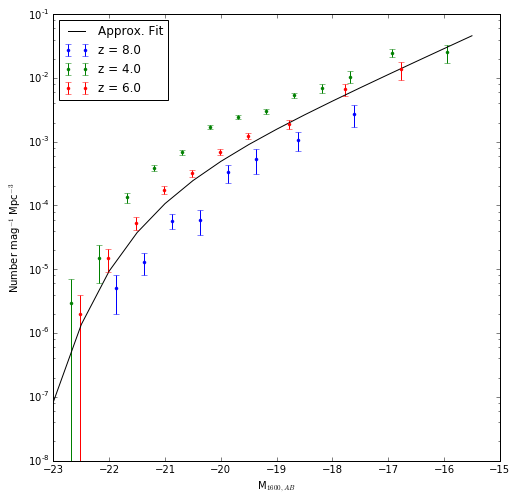

In [127]:
fig, ax = plt.subplots(figsize=[8,8])
plt.plot(maglist,sch,color='k',label='Approx. Fit')
for val in data.keys():
    plt.errorbar(data[val][0],data[val][1],yerr = data[val][2], marker = '.', linestyle = '',label='z = '+str(val))
ax.legend(loc='best')
ax.set_yscale('log')
ax.set_ylabel(r'Number mag$^{-1}$ Mpc$^{-3}$')
ax.set_xlabel(r'M$_{1600,AB}$')
plt.show()

in the above the fit is just to ensure the Schechter function definition is good enough

In [178]:
#trying with an added error term
# theta = [Mstar,logphi,alpha,lnf]
mags = np.asarray(data[4][0])
lum = np.asarray(data[4][1])
err = np.asarray(data[4][2])

In [182]:
def lnlike(theta, x, y, yerr):
    Mstar, logphi, alpha, lnf = theta
    model = schechter_fit(x, 10**logphi, Mstar, alpha)
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    Mstar, logphi, alpha, lnf = theta
    if -25.0 < Mstar < -18.0 and -4.0 < logphi < -1.5 and -4.0 < alpha < -1.0 and -10.0 < lnf < 10.0:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

ndim, nwalkers = 4, 100
pos = [[-23.0,-3.0,-2.0,0.0] + 1.0e-2*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(mags, lum, err))

In [183]:
sampler.run_mcmc(pos, 10000)

(array([[-20.81032194,  -2.69714417,  -1.58943416,  -5.76935939],
        [-20.97020371,  -2.83024345,  -1.7198242 ,  -2.25323212],
        [-20.9500709 ,  -2.81634877,  -1.72683157,  -2.53158907],
        [-20.95281785,  -2.83022654,  -1.67644127,  -2.31558262],
        [-20.95795107,  -2.82936428,  -1.70420654,  -2.46888032],
        [-20.6480293 ,  -2.59500482,  -1.47729215,  -5.70280218],
        [-21.01070113,  -2.82619756,  -1.64982279,  -2.81684468],
        [-20.86365081,  -2.73537453,  -1.64551258,  -2.49650526],
        [-20.80359184,  -2.7108342 ,  -1.6434681 ,  -2.30388988],
        [-21.07720997,  -3.00794718,  -1.76603934,  -1.32021652],
        [-20.54091217,  -2.52559633,  -1.57277772,  -1.36042863],
        [-20.70368406,  -2.65307368,  -1.57081697,  -1.83340515],
        [-20.74882196,  -2.67996056,  -1.6205116 ,  -2.01353432],
        [-21.10444085,  -2.94674394,  -1.72277313,  -1.09133562],
        [-20.86642186,  -2.71524976,  -1.64293471,  -2.81778002],
        [-

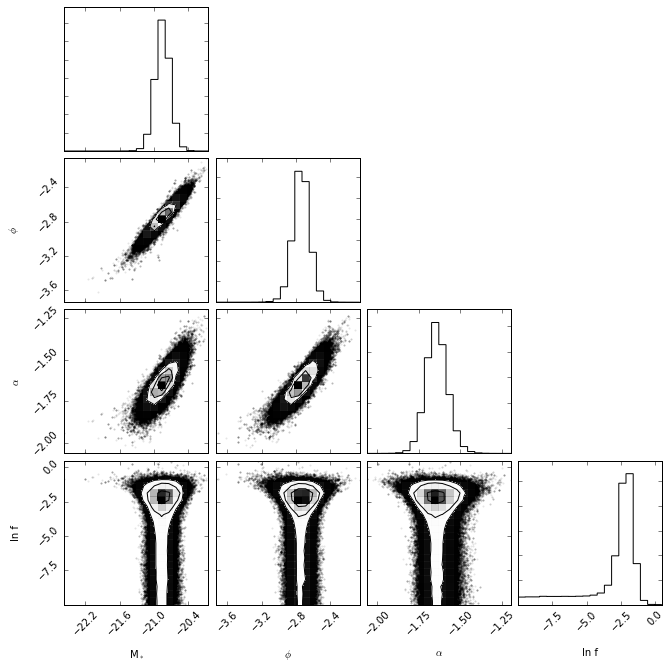

In [184]:
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))

fig = corner.corner(samples, labels=[r"M$_*$", r"$\phi$", r"$\alpha$",r'ln f'])

In [190]:
mags_4 = np.asarray(data[4][0])
lum_4 = np.asarray(data[4][1])
err_4 = np.asarray(data[4][2])

mags_6 = np.asarray(data[6][0])
lum_6 = np.asarray(data[6][1])
err_6 = np.asarray(data[6][2])

mags_8 = np.asarray(data[8][0])
lum_8 = np.asarray(data[8][1])
err_8 = np.asarray(data[8][2])

In [191]:
#here no additional error term, and doing y, the luminosity function, in logspace
def lnlike(theta, x, y, yerr):
    Mstar, logphi, alpha = theta
    model = schechter_fit(x, 10**logphi, Mstar, alpha)
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    Mstar, logphi, alpha = theta
    if -25.0 < Mstar < -18.0 and -4.0 < logphi < -0.5 and -4.0 < alpha < -1.0:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

ndim, nwalkers = 3, 100
pos = [[-23.0,-3.0,-2.0] + 1.0e-2*np.random.randn(ndim) for i in range(nwalkers)]

sampler_4 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(mags_4, lum_4, err_4))
sampler_6 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(mags_6, lum_6, err_6))
sampler_8 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(mags_8, lum_8, err_8))

In [192]:
sampler_4.run_mcmc(pos, 5000)

(array([[-20.79417205,  -2.700124  ,  -1.62259166],
        [-20.82196998,  -2.73776984,  -1.65140306],
        [-20.98319652,  -2.82449878,  -1.66918852],
        [-20.79453341,  -2.72011854,  -1.6439923 ],
        [-20.83909088,  -2.73134706,  -1.68375547],
        [-20.73848884,  -2.66385713,  -1.61160871],
        [-20.96565616,  -2.79869832,  -1.69347141],
        [-20.77408326,  -2.73586296,  -1.67948246],
        [-21.02533036,  -2.88509151,  -1.73668227],
        [-20.87613031,  -2.73754241,  -1.60240019],
        [-21.13244456,  -2.93159347,  -1.74787133],
        [-20.96182382,  -2.79085307,  -1.62424957],
        [-20.84277207,  -2.76212197,  -1.66860709],
        [-20.83783588,  -2.77794062,  -1.65823701],
        [-20.7595775 ,  -2.67264696,  -1.60569373],
        [-20.82254745,  -2.74522402,  -1.6608888 ],
        [-20.65538983,  -2.58200433,  -1.51510334],
        [-21.02048473,  -2.83684509,  -1.67402775],
        [-20.74353551,  -2.6677566 ,  -1.57364963],
        [-20

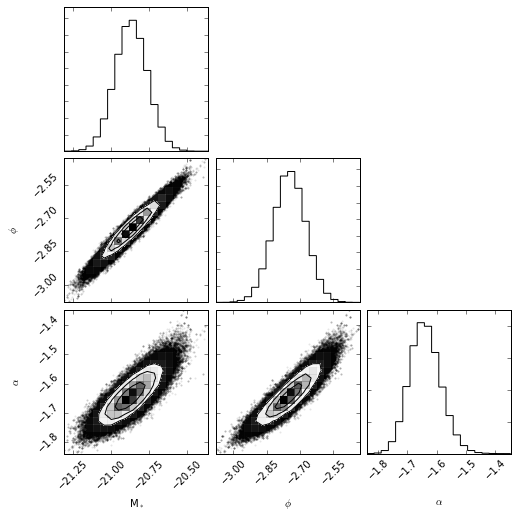

In [193]:
samples_4 = sampler_4.chain[:, 500:, :].reshape((-1, ndim))
fig_4 = corner.corner(samples_4, labels=[r"M$_*$", r"$\phi$", r"$\alpha$"])

In [194]:
sampler_6.run_mcmc(pos, 5000)

(array([[-20.67910604,  -3.07206506,  -1.7890134 ],
        [-20.9279708 ,  -3.2365162 ,  -1.73050811],
        [-21.14935464,  -3.4431686 ,  -1.96190764],
        [-21.22994593,  -3.41427051,  -1.8732687 ],
        [-21.11019762,  -3.37977032,  -1.88540397],
        [-20.72302447,  -3.12427134,  -1.7746339 ],
        [-21.27708264,  -3.58829281,  -2.02291899],
        [-20.80248522,  -3.15876849,  -1.70387226],
        [-21.03042734,  -3.35772078,  -1.92390844],
        [-21.06036068,  -3.36197279,  -1.82092548],
        [-20.95241745,  -3.26195398,  -1.8178511 ],
        [-21.09982478,  -3.40517346,  -1.98732802],
        [-20.73870707,  -3.12084416,  -1.69179234],
        [-20.95275124,  -3.31079624,  -1.84277019],
        [-20.64197855,  -3.06036348,  -1.75972628],
        [-21.0685427 ,  -3.32930218,  -1.83432829],
        [-20.91833427,  -3.22621179,  -1.79871321],
        [-20.98535907,  -3.26774866,  -1.81605194],
        [-20.80374833,  -3.21789308,  -1.94965662],
        [-21

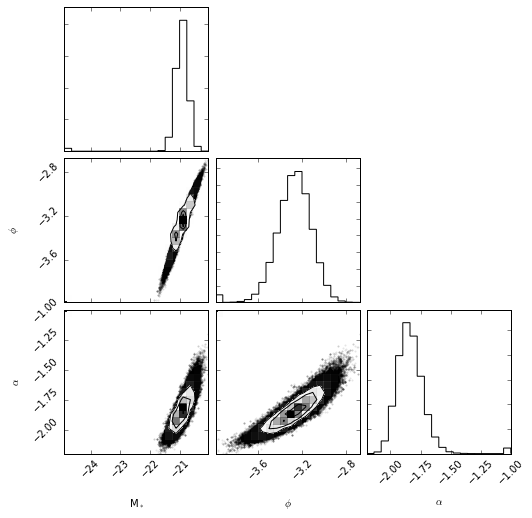

In [195]:
samples_6 = sampler_6.chain[:, 500:, :].reshape((-1, ndim))
fig_6 = corner.corner(samples_6, labels=[r"M$_*$", r"$\phi$", r"$\alpha$"])

In [196]:
sampler_8.run_mcmc(pos, 5000)

(array([[-20.92269923,  -3.99032302,  -2.1017475 ],
        [-20.59461376,  -3.54164092,  -1.89463239],
        [-20.33709051,  -3.4008828 ,  -1.94121859],
        [-20.59756076,  -3.81175055,  -2.01140932],
        [-19.95640309,  -3.278906  ,  -1.8785004 ],
        [-20.16858838,  -3.4075004 ,  -1.79156491],
        [-20.67769502,  -3.78232781,  -2.16270477],
        [-20.71289555,  -3.72098698,  -2.0346605 ],
        [-20.90423904,  -3.95780443,  -2.01306097],
        [-20.38143508,  -3.60809048,  -1.78191267],
        [-20.84038618,  -3.86419043,  -1.91941808],
        [-20.97986991,  -3.95360526,  -2.12685948],
        [-20.57946936,  -3.76401389,  -1.83814431],
        [-20.54427003,  -3.7943401 ,  -1.98944561],
        [-20.54241957,  -3.66431841,  -2.0736222 ],
        [-20.80817228,  -3.91564755,  -2.08655866],
        [-21.04266224,  -3.98663282,  -2.15713669],
        [-20.69670116,  -3.71745548,  -1.95587521],
        [-20.70444725,  -3.87360664,  -2.21257881],
        [-20

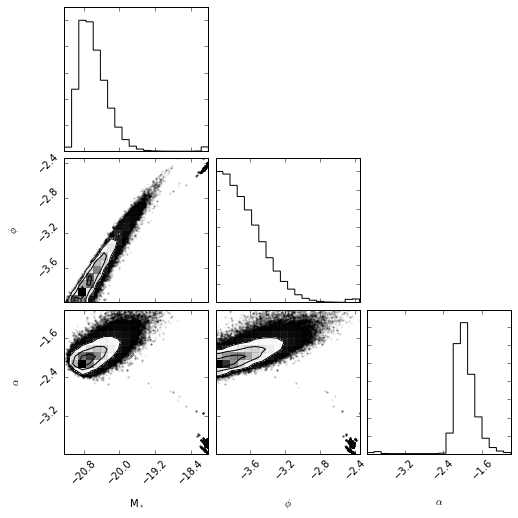

In [197]:
samples_8 = sampler_8.chain[:, 500:, :].reshape((-1, ndim))
fig_8 = corner.corner(samples_8, labels=[r"M$_*$", r"$\phi$", r"$\alpha$"])

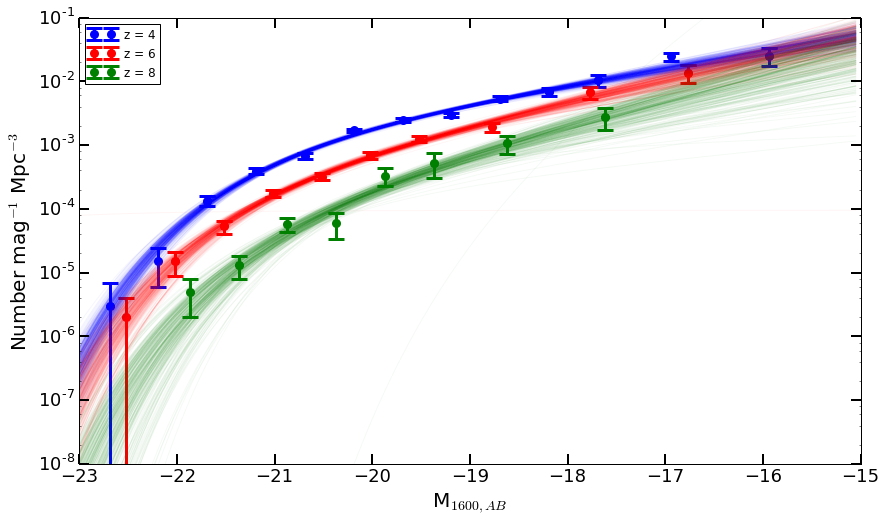

In [217]:
nsamp = len(samples_4)

fig, ax = plt.subplots(figsize=[14,8])

plt.errorbar(data[4][0],data[4][1],yerr = data[4][2], marker = '.', capsize=8, elinewidth=3, markeredgewidth=3, ms=12, linestyle = '',label='z = '+str(4),color='b')
plt.errorbar(data[6][0],data[6][1],yerr = data[6][2], marker = '.', capsize=8, elinewidth=3, markeredgewidth=3, ms=12, linestyle = '',label='z = '+str(6),color='r')
plt.errorbar(data[8][0],data[8][1],yerr = data[8][2], marker = '.', capsize=8, elinewidth=3, markeredgewidth=3, ms=12, linestyle = '',label='z = '+str(8),color='g')


xs = ax.get_xlim()
magvals = np.arange(xs[0],xs[1],0.05)
for j in range(300):
    spl = samples_4[np.random.randint(0,nsamp)]
    thismstar = spl[0]
    thislogphi = spl[1]
    thisalpha = spl[2]
    lfvals = schechter_fit(magvals,10**thislogphi, thismstar, thisalpha)
    ax.plot(magvals,lfvals,color='b',linestyle='-',alpha = 0.04)

for j in range(300):
    spl = samples_6[np.random.randint(0,nsamp)]
    thismstar = spl[0]
    thislogphi = spl[1]
    thisalpha = spl[2]
    lfvals = schechter_fit(magvals,10**thislogphi, thismstar, thisalpha)
    ax.plot(magvals,lfvals,color='r',linestyle='-',alpha = 0.04)
    
for j in range(300):
    spl = samples_8[np.random.randint(0,nsamp)]
    thismstar = spl[0]
    thislogphi = spl[1]
    thisalpha = spl[2]
    lfvals = schechter_fit(magvals,10**thislogphi, thismstar, thisalpha)
    ax.plot(magvals,lfvals,color='g',linestyle='-',alpha = 0.04)
    
ax.legend(loc='best')
ax.set_yscale('log')
ax.set_ylabel(r'Number mag$^{-1}$ Mpc$^{-3}$',fontsize=20)
ax.set_xlabel(r'M$_{1600,AB}$',fontsize=20)
ax.tick_params(labelsize=18,length=10,width=2)
ax.set_ylim([1e-8,1e-1])
plt.show()

In [219]:
print(np.mean(samples_4.T[0]),1e3*10**np.mean(samples_4.T[1]),np.mean(samples_4.T[2]))
print(np.mean(samples_6.T[0]),1e3*10**np.mean(samples_6.T[1]),np.mean(samples_6.T[2]))
print(np.mean(samples_8.T[0]),1e3*10**np.mean(samples_8.T[1]),np.mean(samples_8.T[2]))

(-20.865263370776049, 1.7894085301092704, -1.6388662752294618)
(-20.973525488839801, 0.52843143033042417, -1.8301532371999232)
(-20.563001293120173, 0.21496383596757065, -1.9527512999012033)


Above is a table of mean values for the three parameters M$_*$, $\phi_*$ (10$^{-3}$ Mpc$^{-3}$), and $\alpha$ at redshifts 4, 6, and 8.  Bouwens et al. got

$-20.88 \pm 0.08$ | $1.97^{+0.34}_{-0.29}$  |   $-1.64 \pm 0.04$

$-20.94 \pm 0.20$  |   $0.50^{+0.22}_{-0.16}$  |   $-1.87 \pm 0.10$

$-20.63 \pm 0.36$   |  $0.21^{+0.23}_{-0.11}$   |  $-2.02 \pm 0.23$

All of my values are well within their measurement errors, so it seems the fitting methods produce similar results.

# Problem 3 - Cosmic SFH

From PS 5 I get log(SFR$_{FUV}$) = log(L$_U$) - 28.03.  The first order of business is to convert magnitudes into luminosities using
\begin{equation}
\frac{L}{L_{AB}} = 10^{-0.4(M - M_{AB})}
\end{equation}

and then to convert these luminosities into SFR

In [276]:
def lum_ab(M):
    f0 = 3631e-23 #zero point of the AB system
    M0 = -2.5*np.log10(f0)
    d = 10*3.086e18 #zero point is 10 pc
    
    f_nu = f0*10**(-0.4*M)
    L_nu = 4*np.pi*d**2*f_nu
    return L_nu

All the code between here and heading for 3.1 is pretty much irrelevant - I originally thought I was actually going to use the data from problem 2 here, but it seems there's no need.

In [277]:
M = np.asarray(data[val][0])
print(M,lum_ab(M))


(array([-21.87, -21.37, -20.87, -20.37, -19.87, -19.37, -18.62, -17.62]), array([  2.43236058e+29,   1.53471577e+29,   9.68340188e+28,
         6.10981354e+28,   3.85503172e+28,   2.43236058e+28,
         1.21906807e+28,   4.85319740e+27]))


In [278]:
lum_sfr = {}
lum_sfr['logL'] = {}
lum_sfr['logSFR'] = {}
lum_sfr['n'] = {}
for val in [4,6,8]:
    n = np.asarray(data[val][1])
    M = np.asarray(data[val][0])
    logL = np.log10(lum_ab(M))
    logSFR = logL - 28.03
    lum_sfr['logL'][val] = logL
    lum_sfr['logSFR'][val] = logSFR
    lum_sfr['n'][val] = n   

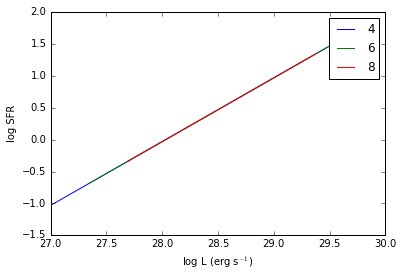

In [279]:
for val in [4,6,8]:
    plt.plot(lum_sfr['logL'][val],lum_sfr['logSFR'][val],label=str(val))
plt.legend()
plt.ylabel('log SFR')
plt.xlabel(r'log L (erg s$^{-1}$)')
plt.show()

## 3.1

Madau & Dickinson give the following way to convert between luminosity density at a given redshift and the Schechter parameters (eq. 14):
\begin{equation}
\rho(z) = \Gamma (2 + \alpha, L_{min}/L_*) \phi L_*
\end{equation}

where $L_{min}$ is the limit of the integral, below which we expect contributions to be negligible: Madau & Dickinson take this to be $0.03 L_*$. $\Gamma$ is the incomplete gamma function:
\begin{equation}
\Gamma(s,x) = \int_{x}^{\infty} t^{s-1} e^{-t} dt
\end{equation}

We need to evaluate this numerically, so we must guess at what value of $t$ this integral becomes negligible. The largest reasonable value of $2 + \alpha$ we can expect is something like $2 + \alpha = 1$, which gives us just $\int_{t_{min}}^{\infty} e^{-t} = 1/e^{t_{min}}$.  Then we can see that the value of this integral is $< 0.001$ when $t_{min} \sim 7$, so we need integrate only to $t = 7$.

In [ ]:
def Gamma(s,x):
    t = np.arange(x,7.01,0.01)
    integral = np.trapz(t**(s-1)*np.exp(-t),dx = 0.01)
    return integral

def lum_density(alpha, phi_star, L_star):
    return phi_star*L_star*Gamma(2+alpha,0.03)

In [281]:
#test that this gives reasonable values
#compare to Madau & Dickinson Figure 9
rho = lum_density(-1.67,8.95e-4,lum_ab(-20.81))
sfrd = np.log10(rho) - 28.03 #from above, converts luminosities to SFRs
print(sfrd)

-1.86981910172


We now need Schechter function parameters.  We get redshifts 0.1 to 3 from Cuccoti et al. (2012) Table B.1, and from redshift 4-8 we can use Finkelstein et al. (2015). Also use Madau & Dickinson (2014) for single redshift 10.4 point.

In [287]:
zs = np.asarray([0.125,0.3,0.5,0.7,0.9,1.1,1.45,2.1,3.0,4,5,6,7,8,10.4])
Mstars = np.asarray([-18.6,-18.3,-18.4,-18.3,-18.7,-19.0,-19.6,-20.7,-20.8,-20.73,-20.81,-21.13,-21.03,-20.89,-20.92])
alphas = np.asarray([-1.10,-1.17,-1.07,-0.90,-0.85,-0.91,-1.09,-1.65,-0.63,-1.56,-1.67,-2.02,-2.03,-2.36,-2.27])
phistars = np.asarray([5.36e-3,6.91e-3,6.60e-3,9.53e-3,9.01e-3,7.43e-3,4.10e-3,2.23e-3,1.72e-3,14.1e-4,8.95e-4,1.86e-4,1.57e-4,0.72e-4,0.008e-3])

In [302]:
print('(z, log SFRD)')
print('-----------------------')
sfrds = []
for i in range(len(zs)):
    alpha, phistar, Mstar = alphas[i],phistars[i],Mstars[i]
    rho = lum_density(alpha,phistar,lum_ab(Mstar))
    sfrd = np.log10(rho) - 28.03
    sfrds.append(sfrd)
    print(zs[i],sfrd)

(z, log SFRD)
-----------------------
(0.125, -2.2136667461524091)
(0.29999999999999999, -2.2043731051919089)
(0.5, -2.2106116244724845)
(0.69999999999999996, -2.1237857274409144)
(0.90000000000000002, -1.9950648054671056)
(1.1000000000000001, -1.9503641242715197)
(1.45, -1.9325423692586021)
(2.1000000000000001, -1.5289575722476805)
(3.0, -1.8912494043360013)
(4.0, -1.7653182237040284)
(5.0, -1.8698191017212373)
(6.0, -2.1822511974751144)
(7.0, -2.2879219357396465)
(8.0, -2.39162029753982)
(10.4, -3.4184420016529202)


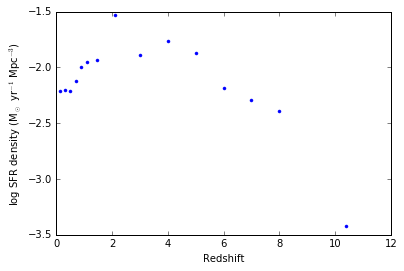

In [296]:
plt.plot(zs,sfrds,marker='.',linestyle = '')
plt.ylabel(r'log SFR density (M$_\odot$ yr$^{-1}$ Mpc$^{-3}$)')
plt.xlabel('Redshift')
plt.show()

These values for the SFRD agree fairly well with the dust-uncorrected values in both Finkelstein et al. (2015) Fig. 19 and Madau & Dickinson (2014) Figure 8.  Having made no attempt to correct for dust extinction this is basically what we'd expect.  The dust-uncorrected values are a factor of about 1 dex different than the dust-corrected values at redshift 2.

I'm not sure the best way to propagate errors all the way through the integration here.

## 3.2

Equation 7 in Finkelstein et al. (2015) reads
\begin{equation}
\phi (z) = A \frac{(1 + z)^\alpha}{1+[(1+z)/B]^{\gamma}}
\end{equation}

where $A$ and $B$ are dimensionless coefficients.  This is the same as Equation 15 from Madau & Dickinson, except that M & D do their fitting in terms of M$_\odot$ yr$^{-1}$ Mpc$^{-3}$ instead of mag$^{-1}$ Mpc$^{-3}$, so the M & D result is more directly comparable.

I'm going to use an error of 0.2 dex everywhere, making a guess based on Madau & Dickinson Table 1 for log SFRD.

In [319]:
sfrds_err = np.ones(len(zs))*0.2
print(sfrds_err)

[ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]


In [320]:
def phi(z,A,B,alpha,gamma):
    ans = A*((1+z)**alpha)/(1 + ((1+z)/B)**gamma)
    return np.log10(ans)

In [321]:
print(phi(4.0, 0.01597804, 2.91075254, 2.68748646, 5.61132406))

-1.25684208068


$\theta =$ A, B, $\alpha$, $\gamma$. Taking the values from Madau and Dickinson as a starting point for my walkers.

In [322]:
def lnlike(theta, x, y, yerr):
    A, B, alpha, gamma = theta
    model = phi(x, A, B, alpha, gamma)
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [323]:
print(lnlike([0.01597804, 2.91075254, 2.68748646, 5.61132406],zs,sfrds,sfrds_err))

-85.9383895012


In [330]:
def lnprior(theta):
    A, B, alpha, gamma = theta
    if 0.0 < A < 0.3 and 1.0 < B < 10.0 and 0.0 < alpha < 5.0 and 2.0 < gamma < 15.0:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

ndim, nwalkers = 4, 100
pos = [[0.015,2.9,2.7,5.6] + 1.0e-2*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(zs, sfrds, sfrds_err))

In [331]:
sampler.run_mcmc(pos, 5000)

(array([[  6.53218009e-03,   7.21645065e+00,   5.83751932e-01,
           9.36803678e+00],
        [  6.83668411e-03,   6.86999208e+00,   5.33512969e-01,
           9.70593034e+00],
        [  8.65182461e-03,   7.20190715e+00,   1.63559467e-01,
           8.56383697e+00],
        [  9.02091894e-03,   8.15160145e+00,   2.28975483e-01,
           1.13326653e+01],
        [  3.00250088e-03,   4.59666477e+00,   1.90392096e+00,
           6.56907294e+00],
        [  6.17194948e-03,   6.41285501e+00,   6.10139681e-01,
           6.39358234e+00],
        [  7.03744542e-03,   6.69373616e+00,   7.73711444e-01,
           9.46104509e+00],
        [  2.54017093e-03,   4.90570817e+00,   1.86667963e+00,
           6.41011117e+00],
        [  3.93875076e-03,   6.35937160e+00,   1.25343606e+00,
           8.44406782e+00],
        [  4.10637438e-03,   6.82980094e+00,   8.81159694e-01,
           7.91218133e+00],
        [  5.75769698e-03,   6.71665950e+00,   7.02013951e-01,
           8.45264998e+00],

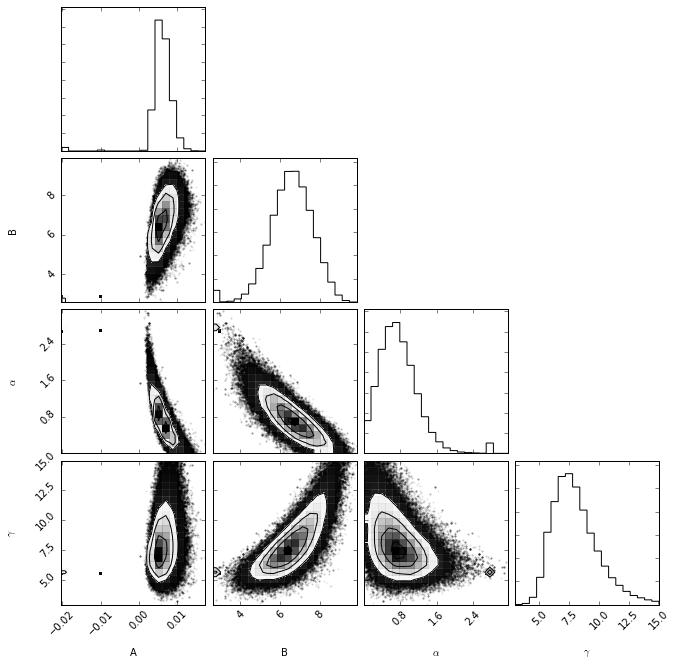

In [332]:
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=['A', 'B', r"$\alpha$", r'$\gamma$'])

In [341]:
A_ret, B_ret, alpha_ret, gamma_ret = np.mean(samples.T[0]),np.mean(samples.T[1]),np.mean(samples.T[2]),np.mean(samples.T[3])

A = 0.00596836683258
B = 6.56472876185
$\alpha$ = 0.776517941545
$\gamma$ = 8.03506541303


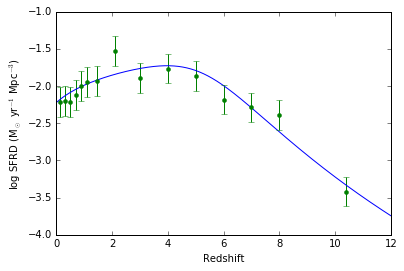

In [340]:
zgrid = np.arange(0,12,0.01)
plt.plot(zgrid, phi(zgrid, A_ret,B_ret,alpha_ret,gamma_ret))
plt.errorbar(zs,sfrds,yerr = sfrds_err,linestyle = '', marker='.',ms=8)
plt.xlabel('Redshift')
plt.ylabel(r'log SFRD (M$_\odot$ yr$^{-1}$ Mpc$^{-3}$)')
plt.show()

In [342]:
print('My values:')
print('A = '+str(A_ret))
print('B = '+str(B_ret))
print(r'$\alpha$ = '+str(alpha_ret))
print(r'$\gamma$ = '+str(gamma_ret))
print('----------------------------')
print('Madau & Dickinson (2014) values:')
print('A = 0.015')
print('B = 2.9')
print(r'$\alpha$ = 2.7')
print(r'$\gamma$ = 5.6')

My values:
A = 0.00596836683258
B = 6.56472876185
$\alpha$ = 0.776517941545
$\gamma$ = 8.03506541303
----------------------------
Madau & Dickinson (2014) values:
A = 0.015
B = 2.9
$\alpha$ = 2.7
$\gamma$ = 5.6


We find quite different values from the Madau & Dickinson paper.  Some sources of this discrepancy might be:

1) We failed to apply any dust correction.  This would have affected $A$, which governs the overall y-axis scaling of the curve, as well as $\alpha$, which governs the slope of the line at low redshift.

2) The M & D paper uses far more samples than I do, especially below a redshift of 3.  My values may be affected significantly by an outlier point or two at z ~ 2-3.

3) Assuming a uniform uncertainty over all redshifts is certainly wrong (though if all the error bars in Table 1 of M & D are to be believed it isn't actually that bad an approximation).  This probably affects the high redshift Universe the most.

4) We assume zero uncertainty in redshift.